In [1]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import metrics
from sklearn.utils import shuffle
from PIL import Image
import mahotas as mh
from mahotas.features import surf
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as skm
from sklearn.cluster import MiniBatchKMeans
import glob
import os
import matplotlib.pyplot as plt

## 用扭曲方法选择K

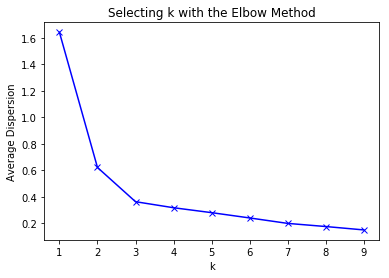

In [4]:
cx1 = np.random.uniform( 0.5, 1.5, (1, 10))
cy1 = np.random.uniform( 0.5, 1.5, (1, 10))
cx2 = np.random.uniform( 3.5, 4.5, (1, 10))
cy2 = np.random.uniform( 3.5, 4.5, (1, 10))
cx3 = np.random.uniform( 1.5, 2.5, (1, 10))
cy3 = np.random.uniform( 1.5, 2.5, (1, 10))

x = np.hstack( (cx1, cx2, cx3) )
y = np.hstack( (cy1, cy2, cy3) )
x = np.vstack( (x, y) ).T

K = range(1, 10)
mean_dispersions = []
for k in K:
    kmeans = KMeans( n_clusters=k )
    kmeans.fit( x )
    mean_dispersions.append( sum(np.min(cdist(x, kmeans.cluster_centers_ , 'euclidean'), axis=1)) / x.shape[0]) 
    
plt.plot( K, mean_dispersions, 'bx-' )
plt.xlabel( 'k' )
plt.ylabel('Average Dispersion')
plt.title('Selecting k with the Elbow Method')
plt.show()

## 评价聚类

In [28]:
plt.subplot(3, 2, 1)
x1 = np.array([1, 2, 3, 1, 5, 6, 5, 5, 6, 7, 8, 9, 7, 9])
x2 = np.array([1, 3, 2, 2, 8, 6, 7, 6, 7, 1, 2, 1, 1, 3])
x = np.array( list(zip(x1, x2)) )

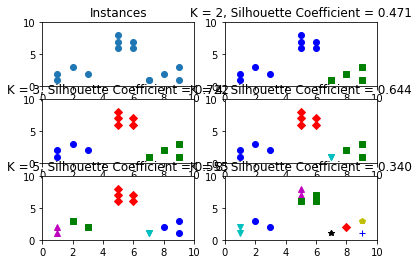

In [29]:
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.title('Instances')
plt.scatter(x1, x2)
colors = list(str('bgrcmykb'))
markers = list(str('osDv^p*+'))
tests = [2, 3, 4, 5, 8]
subplot_counter = 1
for t in tests:
    subplot_counter += 1
    plt.subplot(3, 2, subplot_counter)
    km = KMeans(n_clusters=t).fit(x)
    for i, l in enumerate(km.labels_ ):
        plt.plot( x1[i], x2[i], color=colors[l], marker=markers[l], ls='None')
    plt.xlim([0, 10])
    plt.ylim([0, 10])
    plt.title( 'K = {}, Silhouette Coefficient = {:.3f}'.format(t, 
                metrics.silhouette_score(x, km.labels_, metric='euclidean')))
plt.show()

## 图片分层

In [ ]:
original_img = np.array(Image.open('E:\\MySQL_data\\wechat_friends_img\\image0.jpg'), dtype=np.float64) / 255
original_dimensions = tuple(original_img.shape)
width, height, depth = tuple(original_img.shape)
image_flattened = np.reshape(original_img, (width * height, depth))
image_array_sample = shuffle( image_flattened, random_state=0)[:1000]
estimator = KMeans(n_clusters=64, random_state=0)
estimator.fit( image_array_sample )
cluster_assignments = estimator.predict( image_flattened )
compressed_palette = estimator.cluster_centers_
compressed_img = np.zeros((width, height, compressed_palette.shape[1]))
label_idx = 0
for i in range(width):
    for j in range(height):
        compressed_img[i][j] = compressed_palette[cluster_assignments[label_idx]]
        label_idx += 1

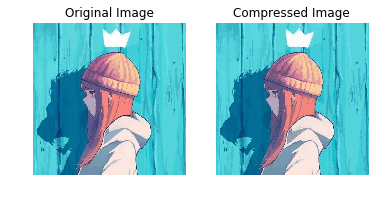

In [37]:
plt.subplot(121)
plt.title( 'Original Image', fontsize=12)
plt.imshow(original_img)
plt.axis('off')
plt.subplot(122)
plt.title('Compressed Image', fontsize=12)
plt.imshow(compressed_img)
plt.axis('off')
plt.show()

## 聚类去学习特征

In [2]:
all_instance_filenames = []
all_instance_targets = []
for f in glob.glob( 'E:\\MySQL_data\\train\\*.jpg'):
    target = 1 if 'cat' in os.path.split(f)[1] else 0
    all_instance_filenames.append(f)
    all_instance_targets.append( target ) 

In [4]:
len(all_instance_filenames)

25000

In [ ]:
surf_features = []
for f in all_instance_filenames:
    image = mh.imread( f, as_grey=True)
    surf_features.append( surf.surf(image)[:, 5:]) 

# 一共两万五千个文件，运行了半个小时都没有结束，放弃了

In [ ]:
train_len = int(len(all_instance_filename) * 0.60 ) 
x_train_surf_feature = np.concatenate( surf_features[:train_len])
x_test_surf_features = np.concatenate( surf_features[train_len:])
y_train = all_instance_targets[:train_len]
y_test = all_instance_targets[train_len:]

In [ ]:
n_clusters = 300
estimator = MiniBatchKMeans( n_clusters=n_clusters )
estimator.fit_transform( x_train_surf_feature )

x_train = []
for instance in surf_features[: train_len]:
    clusters = estimator.predict( instance)
    features = np.bincount( clusters )
    if len(features) < n_clusters:
        features = np.append( features, 
                              np.zeros((1, n_clusters - len(features))) ) 
        x_train.append( features )

x_test = []
for instance in surf_features[ train_len:]:
    clusters = estimator.predict( instance )
    features = np.bincount( clusters )
    if len(features) < n_clusters:
        features = np.append( features, 
                              np.zeros((1, n_clusters - len(features))) )
    x_test.append(features)

clf = LogisticRegression( C=0.001, penalty='12' )
clf.fit( x_train, y_train )
predictions = clf.predict( x_test )
print( classification_report( y_test, predictions) )